This is the GAN training script. It also includes code for creating the pianoroll dataset. Much of this notebook is based on https://colab.research.google.com/github/salu133445/ismir2019tutorial/blob/main/musegan.ipynb.

In [5]:
%load_ext autoreload
%autoreload 2

In [8]:
%pip install dataclasses pretty_midi pypianoroll livelossplot

Note: you may need to restart the kernel to use updated packages.


In [9]:
import csv
import itertools
import pickle
import random
import os
import sys
from dataclasses import dataclass

import numpy as np
import pretty_midi
import pypianoroll
import torch
from matplotlib import pyplot as plt
from pprint import pprint
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from tqdm.notebook import tqdm
from IPython.display import clear_output
from ipywidgets import interact, IntSlider
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

import util

## Data preprocessing

In [10]:
@dataclass
class Chord:
    name: str
    start_time: float
    end_time: float
    token: int


class ChordVocab:
    def __init__(self, chords):
        self._chords = chords.copy()
        self.pad_token = 0

        self.token_to_chord = {i + 1: chord for i, chord in enumerate(self._chords)}
        self.token_to_chord[0] = "PAD"
        self.chord_to_token = {name: i for i, name in self.token_to_chord.items()}
    
    def __len__(self):
        return len(self.token_to_chord)

In [11]:
def get_unique_chords(data_root):
    chords = set()
    for song_idx in sorted(os.listdir(data_root)):
        song_dir = os.path.join(data_root, song_idx)
        if not os.path.isdir(song_dir):
            continue
        chord_path = os.path.join(song_dir, "chord_midi.txt")
        with open(chord_path, newline="") as f:
            reader = csv.reader(f, delimiter="\t")
            chord_data = list(reader)
        for _, _, chord in chord_data:
            chords.add(chord)
    return chords


def make_chord_vocab(data_root, out_path):
    unique_chords = list(get_unique_chords(data_root))
    unique_chords.sort()
    unique_chords.remove("N")
    unique_chords.insert(0, "N")
    with open(out_path, "w") as f:
        for chord in unique_chords:
            f.write(f"{chord}\n")


def load_chord_vocab(vocab_path):
    with open(vocab_path, "r") as f:
        chords = f.read().splitlines()
    return ChordVocab(chords)

In [12]:
make_chord_vocab("../pop909/original", "../data/chord_vocab.txt")
chord_vocab = load_chord_vocab("../data/chord_vocab.txt")
CHORD_VOCAB_SIZE = len(chord_vocab)

In [13]:
def get_chord_data(data_root, chord_vocab):
    song_to_chords = {}
    for song_idx in sorted(os.listdir(data_root)):
        song_dir = os.path.join(data_root, song_idx)
        if not os.path.isdir(song_dir):
            continue
        chord_path = os.path.join(song_dir, "chord_midi.txt")
        with open(chord_path, newline="") as f:
            reader = csv.reader(f, delimiter="\t")
            chord_data = list(reader)
        chords = []
        for start_time, end_time, chord in chord_data:
            chord = Chord(
                chord,
                float(start_time),
                float(end_time),
                chord_vocab.chord_to_token[chord],
            )
            chords.append(chord)
        chords.sort(key=lambda c: c.start_time)
        song_to_chords[song_idx] = chords
    return song_to_chords

In [14]:
song_to_chords = get_chord_data("../pop909/original", chord_vocab)

In [15]:
song_to_chords["001"][:10]

[Chord(name='N', start_time=0.055333, end_time=0.721998, token=1),
 Chord(name='N', start_time=0.721998, end_time=1.388663, token=1),
 Chord(name='N', start_time=1.388663, end_time=2.055328, token=1),
 Chord(name='N', start_time=2.055328, end_time=2.721993, token=1),
 Chord(name='B:maj', start_time=2.721993, end_time=4.055323, token=63),
 Chord(name='C#:maj', start_time=4.055323, end_time=5.388653, token=115),
 Chord(name='Bb:min', start_time=5.388653, end_time=6.721983, token=96),
 Chord(name='Eb:min', start_time=6.721983, end_time=8.055313, token=230),
 Chord(name='B:maj', start_time=8.055313, end_time=9.388643, token=63),
 Chord(name='C#:maj', start_time=9.388643, end_time=10.721973, token=115)]

First, let's visualize one of the midi files in the training set.

In [16]:
m = pypianoroll.load("../data/001/001.npz")
m.trim(end=12 * 96);

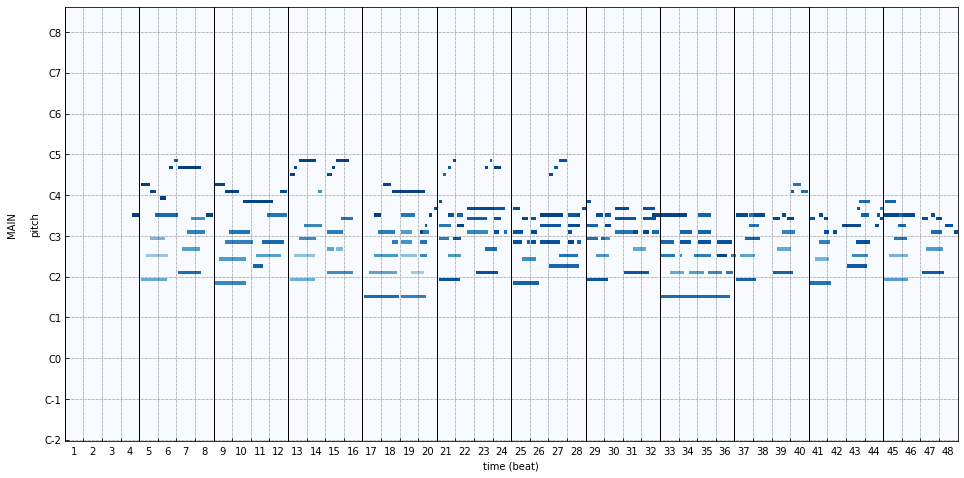

In [17]:
axs = m.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(96, 12 * 96, 96):     
        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

In [18]:
ROOT_DIR = "../data"
song_names = []
for candidate in sorted(os.listdir(ROOT_DIR)):
    if os.path.exists(os.path.join(ROOT_DIR, candidate, f"{candidate}.npz")):
        song_names.append(candidate)
song_names.sort()

                  
def get_midi_path(root_dir, song_name):
    return os.path.join(root_dir, song_name, f"{song_name}.npz")


print(song_names[:5])
print(list(get_midi_path(ROOT_DIR, song_name) for song_name in song_names[:5]))

['001', '002', '003', '004', '005']
['../data/001/001.npz', '../data/002/002.npz', '../data/003/003.npz', '../data/004/004.npz', '../data/005/005.npz']


In [19]:
def get_chords_in_segment(chords, segment_start, segment_end):
    c = []
    for chord in chords:
        if min(chord.end_time, segment_end) >= max(chord.start_time, segment_start):
            c.append(chord)
    c.sort(key=lambda chord: chord.start_time)
    return c

In [20]:
CUDA = torch.cuda.is_available()

BEAT_RESOLUTION = 4
MEASURE_RESOLUTION = BEAT_RESOLUTION * 4
LOWEST_PITCH = 0  # TODO
N_TRACKS = 1
N_PITCHES = 128  # TODO
N_SAMPLES_PER_SONG = 32  # number of samples to extract from each song in the datset
N_MEASURES = 2  # number of measures per sample

# Training
BATCH_SIZE = 16
LATENT_DIM = 128
N_STEPS = 20000

# Sampling
SAMPLE_INTERVAL = 100  # interval to run the sampler (in step)
N_SAMPLES = 4

In [21]:
note_data = []
chord_data = []
# Iterate over all the songs in the ID list
for song_name in tqdm(song_names):
    # Load the multitrack as a pypianoroll.Multitrack instance
    midi_path = get_midi_path(ROOT_DIR, song_name)
    multitrack = pypianoroll.load(midi_path)
    # Binarize the pianorolls
    multitrack.binarize()
    # Downsample the pianorolls (shape: n_timesteps x n_pitches)
    multitrack.set_resolution(BEAT_RESOLUTION)
    # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
    pianoroll = (multitrack.stack() > 0)
    # Get the target pitch range only
    pianoroll = pianoroll[:, :, LOWEST_PITCH:LOWEST_PITCH + N_PITCHES]
    # Calculate the total measures
    n_total_measures = multitrack.get_max_length() // MEASURE_RESOLUTION
    candidate = n_total_measures - N_MEASURES
    target_n_samples = min(n_total_measures // N_MEASURES - 1, N_SAMPLES_PER_SONG)
    # Get speed
    midi_repr = multitrack.to_pretty_midi()
    notes = midi_repr.instruments[0].notes
    duration = notes[-1].end
    measures_per_sec = n_total_measures / duration
    # Randomly select a number of phrases from the multitrack pianoroll
    for idx in np.random.choice(candidate, target_n_samples, replace=False):
        start = idx * MEASURE_RESOLUTION
        end = (idx + N_MEASURES) * MEASURE_RESOLUTION
        # Skip the samples where some track(s) has too few notes
        if (pianoroll.sum(axis=(1, 2)) < 10).any():
            continue
        # Get chords for the segment
        start_sec = idx / measures_per_sec
        end_sec = (idx + N_MEASURES) / measures_per_sec
        chords = get_chords_in_segment(song_to_chords[song_name], start_sec, end_sec)
        # Skip the samples where no chords are present. This shouldn't really happen.
        if len(chords) == 0:
            continue
        note_data.append(pianoroll[:, start:end])
        chord_data.append(chords)

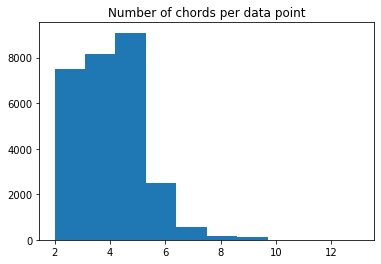

In [22]:
num_chords = [len(chords) for chords in chord_data]
plt.title("Number of chords per data point")
plt.hist(num_chords)
plt.show()

In [23]:
# Stack all the collected pianoroll segments into one big array
note_data_np = np.stack(note_data).squeeze(1)
print(f"Successfully collected {len(note_data_np)} samples from {len(song_names)} songs")
print(f"Data shape : {note_data_np.shape}")

Successfully collected 28068 samples from 909 songs
Data shape : (28068, 32, 128)


In [24]:
# Convert each chord list to a list of tokens
chord_data_ = [
    [c.token for c in chords]
    for chords in chord_data
]

In [25]:
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self, note_data, chord_data):
        """
        Args:
            note_data: np.array
            chord_data: list of np.array
        """
        super().__init__()
        assert note_data.shape[0] == len(chord_data)
        self._note_data = torch.from_numpy(note_data)
        self._chord_data = [torch.LongTensor(cd) for cd in chord_data]
        
    def __len__(self):
        return len(self._chord_data)
    
    def __getitem__(self, idx):
        return {
            "notes": self._note_data[idx],
            "chords": self._chord_data[idx],
        }

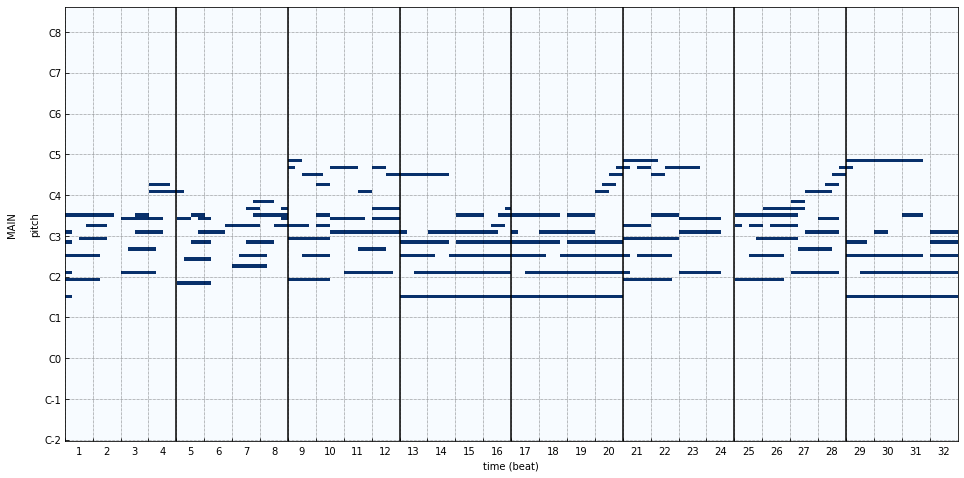

In [26]:
TEMPO = 100

tempo_array = np.full((4 * 4 * MEASURE_RESOLUTION, 1), TEMPO)
tracks = []
sample_data = np.expand_dims(note_data_np, 1)[:4]  # Add fake track dim
pianoroll = np.pad(np.concatenate(sample_data, 1)[0], ((0, 0), (LOWEST_PITCH, 128 - LOWEST_PITCH - N_PITCHES)))
tracks.append(pypianoroll.Track(name="MAIN", program=0, is_drum=False, pianoroll=pianoroll))
multitrack = pypianoroll.Multitrack(tracks=tracks, tempo=tempo_array, resolution=BEAT_RESOLUTION)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(MEASURE_RESOLUTION, 8 * MEASURE_RESOLUTION, MEASURE_RESOLUTION):
        if x % MEASURE_RESOLUTION == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

## Dataset

In [27]:
def collate_fn(samples):
    print(samples)

dataset = MusicDataset(note_data_np, chord_data_)
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=True,
    collate_fn=util.collate_fn,
)

In [28]:
notes, chords = next(iter(data_loader))
print(notes.shape)
print(chords.shape)

torch.Size([16, 32, 128])
torch.Size([16, 6])


## Model definitions

In [29]:
class HighwayEncoder(nn.Module):
    """
    Encode an input sequence using a highway network.

    Based on the paper "Highway Networks"
    by Rupesh Kumar Srivastava, Klaus Greff, Jürgen Schmidhuber
    (https://arxiv.org/abs/1505.00387).

    Args:
        num_layers (int): Number of layers in the highway encoder.
        hidden_size (int): Size of hidden activations.
    
    Based on https://github.com/minggg/squad.
    """

    def __init__(self, num_layers, hidden_size):
        super().__init__()
        self.transforms = nn.ModuleList(
            [nn.Linear(hidden_size, hidden_size) for _ in range(num_layers)]
        )
        self.gates = nn.ModuleList(
            [nn.Linear(hidden_size, hidden_size) for _ in range(num_layers)]
        )

    def forward(self, x):
        for gate, transform in zip(self.gates, self.transforms):
            # Shapes of g, t, and x are all (batch_size, seq_len, hidden_size)
            g = torch.sigmoid(gate(x))
            t = F.relu(transform(x))
            x = g * t + (1 - g) * x
        return x

In [30]:
class ChordEmbedding(torch.nn.Module):
    """
    Based on https://github.com/minggg/squad.
    """

    def __init__(self, hidden_size, num_embeddings, embedding_size, drop_prob, padding_idx=0):
        super().__init__()
        self.drop_prob = drop_prob
        self.embed = nn.Embedding(num_embeddings, embedding_size, padding_idx=padding_idx)
        self.proj = nn.Linear(embedding_size, hidden_size, bias=False)
        self.hwy = HighwayEncoder(num_layers=2, hidden_size=hidden_size)

    def forward(self, x):
        emb = self.embed(x)  # (batch_size, seq_len, embed_size)
        emb = F.dropout(emb, self.drop_prob, self.training)
        emb = self.proj(emb)  # (batch_size, seq_len, hidden_size)
        emb = self.hwy(emb)  # (batch_size, seq_len, hidden_size)
        return emb

In [31]:
class ChordEncoder(nn.Module):
    """General-purpose layer for encoding a sequence using a bidirectional RNN.

    Encoded output is the RNN's hidden state at each position, which
    has shape `(batch_size, seq_len, hidden_size * 2)`.

    Args:
        input_size (int): Size of a single timestep in the input.
        hidden_size (int): Size of the RNN hidden state.
        num_layers (int): Number of layers of RNN cells to use.
        drop_prob (float): Probability of zero-ing out activations.
    
    Based on https://github.com/minggg/squad.
    """

    def __init__(self, input_size, hidden_size, num_layers, drop_prob=0.0):
        super().__init__()
        self.rnn = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=drop_prob if num_layers > 1 else 0.0,
        )
        self.proj = nn.Linear(2 * hidden_size, hidden_size, bias=False)
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, x, lengths):
        # Save original padded length for use by pad_packed_sequence
        orig_len = x.size(1)

        # Sort by length and pack sequence for RNN
        lengths, sort_idx = lengths.sort(0, descending=True)
        x = x[sort_idx]  # (batch_size, seq_len, input_size)
        x = pack_padded_sequence(x, lengths, batch_first=True)

        # Apply RNN
        _, (last_hiddens, _) = self.rnn(x)
        last_hiddens_cat = torch.cat([last_hiddens[0], last_hiddens[1]], dim=1)
        
        out = self.proj(last_hiddens_cat)
        out = self.dropout(out)
        return out

In [32]:
# Test embedding and encoder
emb = ChordEmbedding(8, CHORD_VOCAB_SIZE, 128, 0.0)
enc = ChordEncoder(8, 16, 1)
x = torch.LongTensor(5, 7).random_(0, CHORD_VOCAB_SIZE)
mask = x != torch.zeros_like(x)
x = emb(x)
enc(x, mask.sum(-1)).shape
print(sum(p.numel() for p in emb.parameters() if p.requires_grad))
print(sum(p.numel() for p in enc.parameters() if p.requires_grad))

42400
3840


In [33]:
class GeneratorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.ConvTranspose2d(in_dim, out_dim, kernel, stride)
        self.batchnorm = torch.nn.BatchNorm2d(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.batchnorm(x)
        return torch.nn.functional.relu(x)

In [34]:
class Generator(torch.nn.Module):
    """
    A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector and a chord embedding and outputs a fake sample.
    """
    def __init__(self, hidden_size, chord_vocab_size, chord_emb_size, drop_prob=0.0):
        super().__init__()
        self.chord_emb = ChordEmbedding(
            hidden_size=hidden_size,
            num_embeddings=chord_vocab_size,
            embedding_size=chord_emb_size,
            drop_prob=drop_prob,
        )
        self.chord_enc = ChordEncoder(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=2,
            drop_prob=0.0,
        )
        self.proj = nn.Linear(LATENT_DIM + hidden_size, LATENT_DIM)
        self.hwy = HighwayEncoder(num_layers=2, hidden_size=LATENT_DIM)
        self.transconv0 = GeneratorBlock(LATENT_DIM, 256, (4, 1), (4, 1))
        self.transconv1 = GeneratorBlock(256, 256, (1, 4), (1, 4))
        self.transconv2 = GeneratorBlock(256, 128, (1, 5), (1, 1))
        self.transconv3 = GeneratorBlock(128, 64, (5, 1), (1, 1))
        self.transconv4 = GeneratorBlock(64, 64, (1, 1), (1, 1))

    def forward(self, z, chords):
        batch_size, latent_dim = z.size()
        
        # Transform chord sequences into fixed size vectors
        mask = chords != torch.zeros_like(chords)
        lengths = mask.sum(-1)
        chord_emb = self.chord_emb(chords)
        chord_enc = self.chord_enc(chord_emb, lengths)
        
        z = torch.cat([z, chord_enc], dim=1)
        z = self.proj(z)
        z = self.hwy(z)
        z = z.view(-1, latent_dim, 1, 1)
        z = self.transconv0(z)
        z = self.transconv1(z)
        z = self.transconv2(z)
        z = self.transconv3(z)
        z = self.transconv4(z)
        z = z.view(batch_size, N_MEASURES * MEASURE_RESOLUTION, N_PITCHES)
        return z

In [35]:
# Test generator
g = Generator(hidden_size=64, chord_vocab_size=CHORD_VOCAB_SIZE, chord_emb_size=96)
print(f"Num params: {sum(p.numel() for p in g.parameters() if p.requires_grad)}")
z = torch.randn((5, LATENT_DIM))
test_chords = torch.LongTensor(5, 8).random_(0, 13)
test_fake = g(z, test_chords)
print(f"Generator output shape: {test_fake.shape}")

Num params: 922848
Generator output shape: torch.Size([5, 32, 128])


In [36]:
class LayerNorm(torch.nn.Module):
    """
    An implementation of Layer normalization that does not require size
    information. Copied from https://github.com/pytorch/pytorch/issues/1959.
    """
    def __init__(self, n_features, eps=1e-5, affine=True):
        super().__init__()
        self.n_features = n_features
        self.affine = affine
        self.eps = eps
        if self.affine:
            self.gamma = torch.nn.Parameter(torch.Tensor(n_features).uniform_())
            self.beta = torch.nn.Parameter(torch.zeros(n_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

In [37]:
class DiscriminatorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.Conv2d(in_dim, out_dim, kernel, stride)
        self.layernorm = LayerNorm(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.layernorm(x)
        return torch.nn.functional.leaky_relu(x)

In [38]:
class Discriminator(torch.nn.Module):
    """
    A convolutional neural network (CNN) based discriminator. The
    discriminator takes as input either a real sample (in the training data) or
    a fake sample (generated by the generator) and outputs a scalar indicating
    its authentity.
    """
    def __init__(self, hidden_size, chord_vocab_size, chord_emb_size, drop_prob=0.0):
        super().__init__()
        self.chord_emb = ChordEmbedding(
            hidden_size=hidden_size,
            num_embeddings=chord_vocab_size,
            embedding_size=chord_emb_size,
            drop_prob=drop_prob,
        )
        self.chord_enc = ChordEncoder(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=2,
            drop_prob=0.0,
        )
        self.conv0 = DiscriminatorBlock(2, 16, (1, 12), (1, 12))
        self.conv1 = DiscriminatorBlock(16, 16, (4, 1), (4, 1))
        self.conv2 = DiscriminatorBlock(16, 64, (1, 3), (1, 1))
        self.conv3 = DiscriminatorBlock(64, 64, (1, 4), (1, 4))
        self.conv4 = DiscriminatorBlock(64, 128, (4, 1), (4, 1))
        self.conv5 = DiscriminatorBlock(128, 128, (1, 1), (1, 1))
        self.conv6 = DiscriminatorBlock(128, 256, (1, 1), (1, 2))
        self.proj = nn.Linear(256 + hidden_size, hidden_size)
        self.hwy = HighwayEncoder(num_layers=2, hidden_size=hidden_size)
        self.dense = torch.nn.Linear(hidden_size, 1)
        

    def forward(self, x, chords):
        batch_size, _, _ = x.size()

        # Transform chord sequences into fixed size vectors
        mask = chords != torch.zeros_like(chords)
        lengths = mask.sum(-1)
        chord_emb = self.chord_emb(chords)
        chord_enc = self.chord_enc(chord_emb, lengths)
        
        # Process fake note sequences
        x = x.view(-1, N_MEASURES, MEASURE_RESOLUTION, N_PITCHES)
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(batch_size, 256)
        
        # Combine both representations
        x = torch.cat([x, chord_enc], dim=1)
        x = self.proj(x)
        x = self.hwy(x)
        x = self.dense(x)
        return x

In [39]:
# Test discriminator
d = Discriminator(64, CHORD_VOCAB_SIZE, 96)
d(test_fake, test_chords)

tensor([[-0.0851],
        [-0.1328],
        [-0.1409],
        [-0.1428],
        [-0.1226]], grad_fn=<AddmmBackward>)

## Training functions

In [40]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, chords):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1)
    if torch.cuda.is_available():
        alpha = alpha.cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates, chords)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.size(0), 1)
    if torch.cuda.is_available():
        fake = fake.cuda()
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [41]:
def train_one_step(d_optimizer, g_optimizer, real_samples, chords):
    """Train the networks for one step."""
    # Sample from the lantent distribution
    latent = torch.randn(BATCH_SIZE, LATENT_DIM)

    # Transfer data to GPU
    if torch.cuda.is_available():
        real_samples = real_samples.cuda()
        chords = chords.cuda()
        latent = latent.cuda()
    
    # === Train the discriminator ===
    # Reset cached gradients to zero
    d_optimizer.zero_grad()
    # Get discriminator outputs for the real samples
    prediction_real = discriminator(real_samples, chords)
    # Compute the loss function
    # d_loss_real = torch.mean(torch.nn.functional.relu(1. - prediction_real))
    d_loss_real = -torch.mean(prediction_real)
    # Backpropagate the gradients
    d_loss_real.backward()
    
    # Generate fake samples with the generator
    fake_samples = generator(latent, chords)
    # Get discriminator outputs for the fake samples
    prediction_fake_d = discriminator(fake_samples.detach(), chords)
    # Compute the loss function
    # d_loss_fake = torch.mean(torch.nn.functional.relu(1. + prediction_fake_d))
    d_loss_fake = torch.mean(prediction_fake_d)
    # Backpropagate the gradients
    d_loss_fake.backward()

    # Compute gradient penalty
    gradient_penalty = 10.0 * compute_gradient_penalty(
        discriminator, real_samples.data, fake_samples.data, chords,
    )
    # Backpropagate the gradients
    gradient_penalty.backward()

    # Update the weights
    d_optimizer.step()
    
    # === Train the generator ===
    # Reset cached gradients to zero
    g_optimizer.zero_grad()
    # Get discriminator outputs for the fake samples
    prediction_fake_g = discriminator(fake_samples, chords)
    # Compute the loss function
    g_loss = -torch.mean(prediction_fake_g)
    # Backpropagate the gradients
    g_loss.backward()
    # Update the weights
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

## Training setup

In [45]:
# Create data loader.
# data_loader = get_data_loader()

# Create neural networks.
discriminator = Discriminator(
    hidden_size=128,
    chord_vocab_size=CHORD_VOCAB_SIZE,
    chord_emb_size=128,
)
generator = Generator(
    hidden_size=128,
    chord_vocab_size=CHORD_VOCAB_SIZE,
    chord_emb_size=128,
)
print("Number of parameters in G: {}".format(
    sum(p.numel() for p in generator.parameters() if p.requires_grad))
)
print("Number of parameters in D: {}".format(
    sum(p.numel() for p in discriminator.parameters() if p.requires_grad))
)

# Create optimizers.
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9),
)
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.5, 0.9),
)

# Prepare the inputs for the sampler, which will run during training.
sample_latent = torch.randn(1, LATENT_DIM)
sample_chords = torch.LongTensor([[284,  88, 222,  37]])

# Transfer the neural nets and samples to GPU.
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()
    sample_chords = sample_chords.cuda()

# Create an empty dictionary to sotre history samples.
history_samples = {}

# Create a LiveLoss logger instance for monitoring.
liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6, 2))])

# Initialize step.
step = 0

Number of parameters in G: 1519104
Number of parameters in D: 1036001


In [46]:
generator(sample_latent, sample_chords).shape

torch.Size([1, 32, 128])

## Training

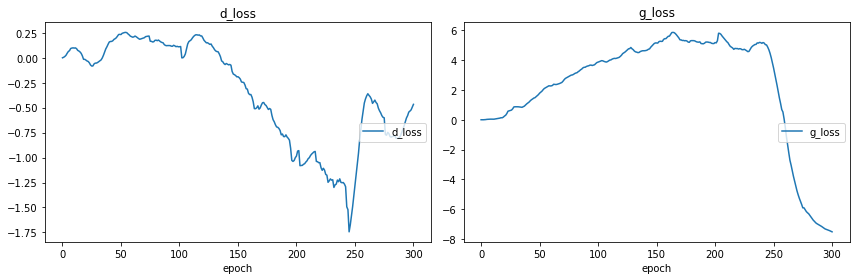

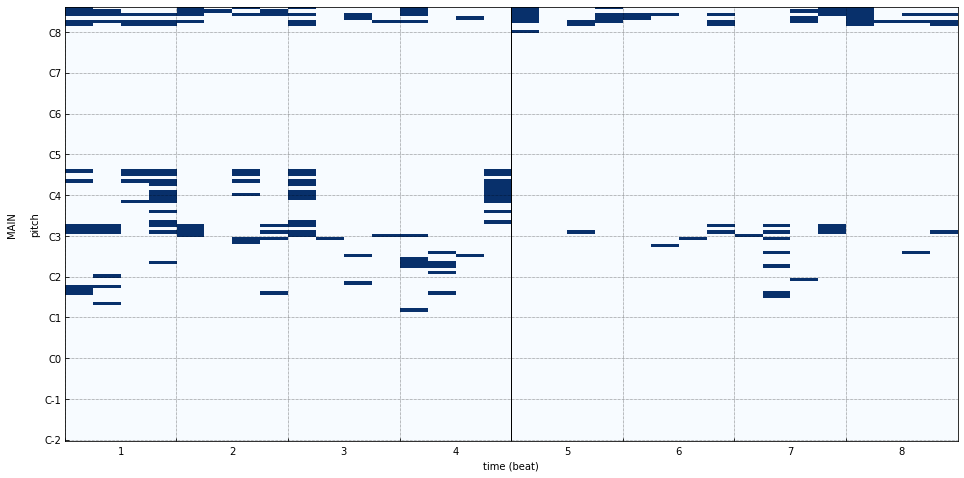

Step 300 	 D-loss: 0.062719 	 G-loss: -8.248637


KeyboardInterrupt: 

In [47]:
# Create a progress bar instance for monitoring
# progress_bar = tqdm(total=N_STEPS, initial=step, ncols=80, mininterval=1)
LOG_EVERY_N = 100

# Start iterations
while step < N_STEPS + 1:
    # Iterate over the dataset
    for real_samples, chords in data_loader:
        real_samples = real_samples.float()

        # Train the neural networks
        generator.train()
        d_loss, g_loss = train_one_step(d_optimizer, g_optimizer, real_samples, chords)

        # Record smoothened loss values to LiveLoss logger
        if step > 0:
            running_d_loss = 0.05 * d_loss + 0.95 * running_d_loss
            running_g_loss = 0.05 * g_loss + 0.95 * running_g_loss
        else:
            running_d_loss, running_g_loss = 0.0, 0.0
        # liveloss.update({'negative_critic_loss': -running_d_loss})
        liveloss.update({'d_loss': running_d_loss, 'g_loss': running_g_loss})
        
        # Update losses to progress bar
        # progress_bar.set_description_str(
        #     "(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))
        
        if step % SAMPLE_INTERVAL == 0:
            # Get generated samples
            generator.eval()
            samples = generator(sample_latent, sample_chords).cpu().detach().numpy()
            history_samples[step] = samples

            # Display loss curves
            clear_output(True)
            if step > 0:
                liveloss.send()
            
            # Display generated samples
            samples = np.expand_dims(samples, 1)  # Add fake track dim
            samples = samples.reshape(1, -1, N_PITCHES)
            pianoroll = np.pad(
                samples[0].squeeze() > 0.5,
                ((0, 0), (LOWEST_PITCH, 128 - LOWEST_PITCH - N_PITCHES))
            )
            tracks = [
                pypianoroll.Track(
                    name="MAIN",
                    program=0,
                    is_drum=False,
                    pianoroll=pianoroll
                )
            ]
            m = pypianoroll.Multitrack(
                tracks=tracks,
                tempo=tempo_array,
                resolution=BEAT_RESOLUTION
            )
            axs = m.plot()
            plt.gcf().set_size_inches((16, 8))
            for ax in axs:
                for x in range(
                    MEASURE_RESOLUTION,
                    MEASURE_RESOLUTION * N_MEASURES,
                    MEASURE_RESOLUTION
                ):
                    if x % (MEASURE_RESOLUTION * 4) == 0:
                        ax.axvline(x - 0.5, color='k')
                    else:
                        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
            plt.show()
        
        if step % LOG_EVERY_N == 0:
            print(f"Step {step} \t D-loss: {d_loss:.6f} \t G-loss: {g_loss:.6f}")
            
        step += 1
        # progress_bar.update(1)
        if step >= N_STEPS:
            break